# Model training for birds, cats, dogs

In [3]:
import os
import shutil
import random
import zipfile
import tarfile
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To ignore some warnings about Image metadata that Pillow prints out
import warnings
warnings.filterwarnings("ignore")

## dataset download link
https://storage.googleapis.com/mlep-public/course_1/week2/kagglecatsanddogs_3367a.zip

https://storage.googleapis.com/mlep-public/course_1/week2/CUB_200_2011.tar



In [4]:
with zipfile.ZipFile('kagglecatsanddogs_3367a.zip', 'r') as my_zip:
  my_zip.extractall()

In [5]:
with tarfile.open('CUB_200_2011.tar', 'r') as my_tar:
  my_tar.extractall()

In [6]:
base_dogs_dir = 'PetImages/Dog'
base_cats_dir = 'PetImages/Cat'

print(f"There are {len(os.listdir(base_dogs_dir))} images of dogs")
print(f"There are {len(os.listdir(base_cats_dir))} images of cats")

There are 12501 images of dogs
There are 12501 images of cats


In [7]:
raw_birds_dir = 'CUB_200_2011/images'
base_birds_dir = 'PetImages/Bird'
os.mkdir(base_birds_dir)

for subdir in os.listdir(raw_birds_dir):
  subdir_path = os.path.join(raw_birds_dir, subdir)
  for image in os.listdir(subdir_path):
    shutil.move(os.path.join(subdir_path, image), os.path.join(base_birds_dir))

print(f"There are {len(os.listdir(base_birds_dir))} images of birds")

There are 11788 images of birds


Sample cat image:


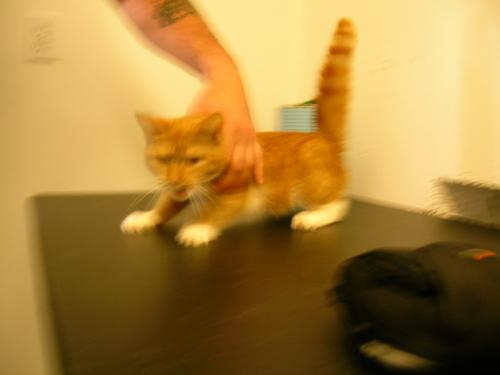


Sample dog image:


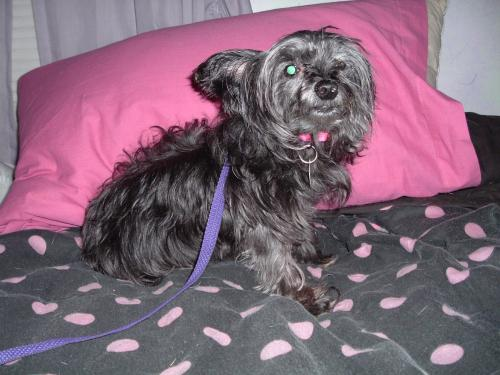


Sample bird image:


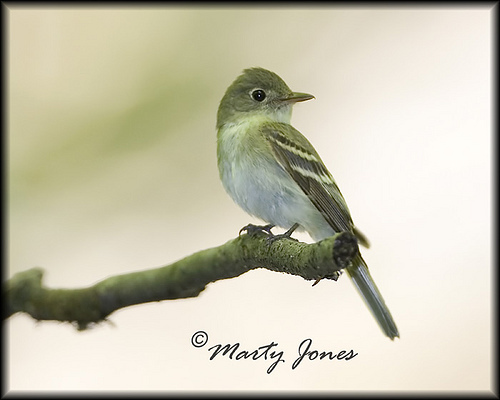

In [8]:
from IPython.display import Image, display

print("Sample cat image:")
display(Image(filename=f"{os.path.join(base_cats_dir, os.listdir(base_cats_dir)[0])}"))
print("\nSample dog image:")
display(Image(filename=f"{os.path.join(base_dogs_dir, os.listdir(base_dogs_dir)[0])}"))
print("\nSample bird image:")
display(Image(filename=f"{os.path.join(base_birds_dir, os.listdir(base_birds_dir)[0])}"))

## Train / Evaluate Split

In [9]:
train_eval_dirs = ['train/cats', 'train/dogs', 'train/birds',
                   'eval/cats', 'eval/dogs', 'eval/birds']

for dir in train_eval_dirs:
  #if not os.path.exists(os.path.join(base_dir, dir)):
    os.makedirs(dir)

Now, let's define a function that will move a percentage of images from an origin folder to a destination folder as desired to generate the training and evaluation splits:

In [10]:
def move_to_destination(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.move(os.path.join(origin, image_name), destination)

And now you are ready to call the previous function and split the data:

In [11]:
# Move 70% of the images to the train dir
move_to_destination(base_cats_dir, 'train/cats', 0.7)
move_to_destination(base_dogs_dir, 'train/dogs', 0.7)
move_to_destination(base_birds_dir,'train/birds', 0.7)


# Move the remaining images to the eval dir
move_to_destination(base_cats_dir, 'eval/cats', 1)
move_to_destination(base_dogs_dir, 'eval/dogs', 1)
move_to_destination(base_birds_dir, 'eval/birds', 1)

Something important to mention is that as it currently stands your dataset has some issues that will prevent model training and evaluation. Mainly:

1. Some images are corrupted and have zero bytes.
2. Cats vs dogs zip file included a `.db` file for each class that needs to be deleted.

we have to remove those files contain zero bytes and `.db` extensions by going to the respective folder and filter it by size and type.

In [12]:
print(f"There are {len(os.listdir('train/cats'))} images of cats for training")
print(f"There are {len(os.listdir('train/dogs'))} images of dogs for training")
print(f"There are {len(os.listdir('train/birds'))} images of birds for training\n")

print(f"There are {len(os.listdir('eval/cats'))} images of cats for evaluation")
print(f"There are {len(os.listdir('eval/dogs'))} images of dogs for evaluation")
print(f"There are {len(os.listdir('eval/birds'))} images of birds for evaluation")

There are 8750 images of cats for training
There are 8749 images of dogs for training
There are 8251 images of birds for training

There are 3749 images of cats for evaluation
There are 3750 images of dogs for evaluation
There are 3537 images of birds for evaluation


In [13]:
for dir in train_eval_dirs:
  if not os.path.exists('imbalanced/'+ dir):
    os.makedirs('imbalanced/'+ dir)

In [14]:
# Very similar to the one used before but this one copies instead of moving
def copy_with_limit(origin, destination, percentage_split):
  num_images = int(len(os.listdir(origin))*percentage_split)
  for image_name, image_number in zip(sorted(os.listdir(origin)), range(num_images)):
    shutil.copy(os.path.join(origin, image_name), destination)

# Perform the copying
copy_with_limit('train/cats','imbalanced/train/cats', 1)
copy_with_limit('train/dogs','imbalanced/train/dogs', 0.2)
copy_with_limit('train/birds','imbalanced/train/birds', 0.1)

copy_with_limit('eval/cats','imbalanced/eval/cats', 1)
copy_with_limit('eval/dogs', 'imbalanced/eval/dogs', 0.2)
copy_with_limit('eval/birds', 'imbalanced/eval/birds', 0.1)

# Print number of available images
print(f"There are {len(os.listdir('imbalanced/train/cats'))} images of cats for training")
print(f"There are {len(os.listdir('imbalanced/train/dogs'))} images of dogs for training")
print(f"There are {len(os.listdir('imbalanced/train/birds'))} images of birds for training\n")

print(f"There are {len(os.listdir('imbalanced/eval/cats'))} images of cats for evaluation")
print(f"There are {len(os.listdir('imbalanced/eval/dogs'))} images of dogs for evaluation")
print(f"There are {len(os.listdir('imbalanced/eval/birds'))} images of birds for evaluation")

There are 8750 images of cats for training
There are 1749 images of dogs for training
There are 825 images of birds for training

There are 3749 images of cats for evaluation
There are 750 images of dogs for evaluation
There are 353 images of birds for evaluation


In [15]:
from tensorflow.keras import layers, models, optimizers

def create_model():
  # A simple CNN architecture based on the one found here: https://www.tensorflow.org/tutorials/images/classification
  model = models.Sequential([
  layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(3, activation='softmax')
  ])


  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      optimizer=optimizers.Adam(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
  )

  return model

In [16]:
# Create a model to use with the imbalanced dataset
imbalanced_model = create_model()

# Print the model's summary
print(imbalanced_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# No data augmentation for now, only normalizing pixel values
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Point to the imbalanced directory
train_generator = train_datagen.flow_from_directory(
        'imbalanced/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'imbalanced/eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 11324 images belonging to 3 classes.
Found 4852 images belonging to 3 classes.


Let's do a quick sanity check to inspect that both generators (training and validation) use the same labels for each class:

In [18]:
print(f"labels for each class in the train generator are: {train_generator.class_indices}")
print(f"labels for each class in the validation generator are: {validation_generator.class_indices}")

labels for each class in the train generator are: {'birds': 0, 'cats': 1, 'dogs': 2}
labels for each class in the validation generator are: {'birds': 0, 'cats': 1, 'dogs': 2}



# Training a CNN with class imbalanced data


In [22]:
# Load pretrained model and history

#imbalanced_history = pd.read_csv('history-imbalanced/history-imbalanced.csv')
#imbalanced_model = tf.keras.models.load_model('model-imbalanced')


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14706680447101851327
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1755224475
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7275426142571624525
physical_device_desc: "device: 0, name: GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [19]:
 #Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

imbalanced_history = imbalanced_model.fit(
     train_generator,
     steps_per_epoch=100,
     epochs=50,
     validation_data=validation_generator,
     validation_steps=80)

Epoch 1/50
100/100 [==============================] - 13s 68ms/step - loss: 0.7123 - sparse_categorical_accuracy: 0.7697 - val_loss: 0.6528 - val_sparse_categorical_accuracy: 0.7719
Epoch 2/50
100/100 [==============================] - 7s 69ms/step - loss: 0.6168 - sparse_categorical_accuracy: 0.7841 - val_loss: 0.5265 - val_sparse_categorical_accuracy: 0.8062
Epoch 3/50
100/100 [==============================] - 7s 65ms/step - loss: 0.5546 - sparse_categorical_accuracy: 0.7959 - val_loss: 0.5333 - val_sparse_categorical_accuracy: 0.7988
Epoch 4/50
100/100 [==============================] - 7s 67ms/step - loss: 0.5229 - sparse_categorical_accuracy: 0.8037 - val_loss: 0.4719 - val_sparse_categorical_accuracy: 0.8227
Epoch 5/50
100/100 [==============================] - 7s 68ms/step - loss: 0.4959 - sparse_categorical_accuracy: 0.8184 - val_loss: 0.4862 - val_sparse_categorical_accuracy: 0.8184
Epoch 6/50
100/100 [==============================] - 7s 71ms/step - loss: 0.4724 - sparse_cat

100/100 [==============================] - 7s 66ms/step - loss: 0.0285 - sparse_categorical_accuracy: 0.9916 - val_loss: 0.8743 - val_sparse_categorical_accuracy: 0.8551
Epoch 47/50
100/100 [==============================] - 7s 67ms/step - loss: 0.0308 - sparse_categorical_accuracy: 0.9897 - val_loss: 0.8589 - val_sparse_categorical_accuracy: 0.8516
Epoch 48/50
100/100 [==============================] - 7s 69ms/step - loss: 0.0484 - sparse_categorical_accuracy: 0.9850 - val_loss: 0.7285 - val_sparse_categorical_accuracy: 0.8492
Epoch 49/50
100/100 [==============================] - 7s 67ms/step - loss: 0.0277 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.8187 - val_sparse_categorical_accuracy: 0.8477
Epoch 50/50
100/100 [==============================] - 7s 68ms/step - loss: 0.0405 - sparse_categorical_accuracy: 0.9881 - val_loss: 0.7414 - val_sparse_categorical_accuracy: 0.8234


To analyze the model performance properly, it is important to track different metrics such as accuracy and loss function along the training process. Let's define a helper function to handle the metrics through the training history,depending on the method you previously selected:

In [20]:
def get_training_metrics(history):
  
  # This is needed depending on if you used the pretrained model or you trained it yourself
  if not isinstance(history, pd.core.frame.DataFrame):
    history = history.history
  
  acc = history['sparse_categorical_accuracy']
  val_acc = history['val_sparse_categorical_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']

  return acc, val_acc, loss, val_loss

Now, let's plot the metrics and losses for each training epoch as the training process progresses. 

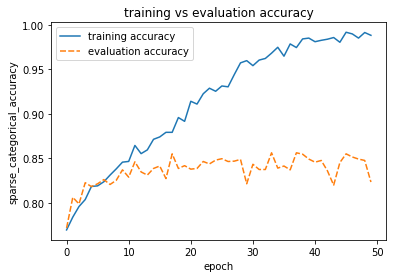

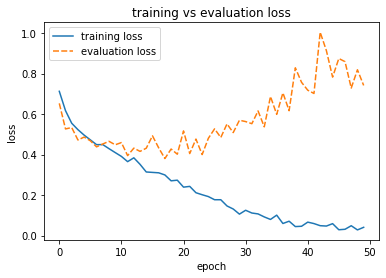

In [21]:
def plot_train_eval(history):
  acc, val_acc, loss, val_loss = get_training_metrics(history)

  acc_plot = pd.DataFrame({"training accuracy":acc, "evaluation accuracy":val_acc})
  acc_plot = sns.lineplot(data=acc_plot)
  acc_plot.set_title('training vs evaluation accuracy')
  acc_plot.set_xlabel('epoch')
  acc_plot.set_ylabel('sparse_categorical_accuracy')
  plt.show()

  print("")

  loss_plot = pd.DataFrame({"training loss":loss, "evaluation loss":val_loss})
  loss_plot = sns.lineplot(data=loss_plot)
  loss_plot.set_title('training vs evaluation loss')
  loss_plot.set_xlabel('epoch')
  loss_plot.set_ylabel('loss')
  plt.show()



plot_train_eval(imbalanced_history)

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score

In [24]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    'imbalanced/eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 4852 images belonging to 3 classes.


In [25]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_imbalanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_imbalanced)}")

Accuracy Score: 0.8200741962077494
Balanced Accuracy Score: 0.7354903291386569


Comparing the `accuracy` and `balanced accuracy` metrics, the class imbalance starts to become apparent. Now let's compute the `confusion matrix` of the predictions. Notice that the class imbalance is also present in the evaluation set so the confusion matrix will show an overwhelming majority for cats.

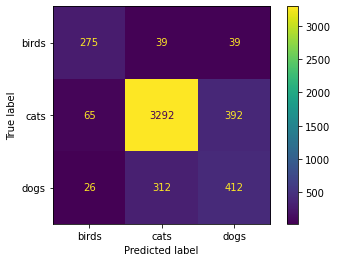

In [26]:
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

In [27]:
misclassified_birds = (imbalanced_cm[1,0] + imbalanced_cm[2,0])/np.sum(imbalanced_cm, axis=0)[0]
misclassified_cats = (imbalanced_cm[0,1] + imbalanced_cm[2,1])/np.sum(imbalanced_cm, axis=0)[1]
misclassified_dogs = (imbalanced_cm[0,2] + imbalanced_cm[1,2])/np.sum(imbalanced_cm, axis=0)[2]

print(f"Proportion of misclassified birds: {misclassified_birds*100:.2f}%")
print(f"Proportion of misclassified cats: {misclassified_cats*100:.2f}%")
print(f"Proportion of misclassified dogs: {misclassified_dogs*100:.2f}%")

Proportion of misclassified birds: 24.86%
Proportion of misclassified cats: 9.63%
Proportion of misclassified dogs: 51.13%


In [28]:
# Predict cat for all images
all_cats = np.ones(y_true.shape)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, all_cats)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, all_cats)}")

Accuracy Score: 0.7726710634789777
Balanced Accuracy Score: 0.3333333333333333


Found 11036 images belonging to 3 classes.


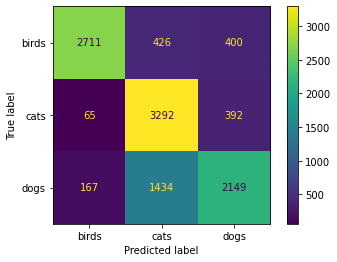

In [30]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    'eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_imbalanced = imbalanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_imbalanced = np.argmax(predictions_imbalanced, axis=1)

# Confusion matrix
imbalanced_cm = confusion_matrix(y_true, y_pred_imbalanced)
ConfusionMatrixDisplay(imbalanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

# Training with the complete dataset



In [31]:
# Create a model to use with the balanced dataset
balanced_model = create_model()

In [33]:
# Still no data augmentation, only re-scaling
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generators now point to the complete dataset
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.


In [35]:
# Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

balanced_history = balanced_model.fit(
    train_generator,
     steps_per_epoch=100,
     epochs=50,
     validation_data=validation_generator,
     validation_steps=80)

Epoch 1/50
100/100 [==============================] - 9s 82ms/step - loss: 0.9852 - sparse_categorical_accuracy: 0.4781 - val_loss: 0.8138 - val_sparse_categorical_accuracy: 0.5992
Epoch 2/50
100/100 [==============================] - 8s 76ms/step - loss: 0.7812 - sparse_categorical_accuracy: 0.6137 - val_loss: 0.7539 - val_sparse_categorical_accuracy: 0.6176
Epoch 3/50
100/100 [==============================] - 8s 78ms/step - loss: 0.7101 - sparse_categorical_accuracy: 0.6538 - val_loss: 0.7452 - val_sparse_categorical_accuracy: 0.6844
Epoch 4/50
100/100 [==============================] - 8s 78ms/step - loss: 0.7309 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.6674 - val_sparse_categorical_accuracy: 0.6895
Epoch 5/50
100/100 [==============================] - 8s 84ms/step - loss: 0.6690 - sparse_categorical_accuracy: 0.6991 - val_loss: 0.6459 - val_sparse_categorical_accuracy: 0.6828
Epoch 6/50
100/100 [==============================] - 8s 78ms/step - loss: 0.6278 - sparse_cate

100/100 [==============================] - 8s 77ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.9488 - val_loss: 0.3971 - val_sparse_categorical_accuracy: 0.8566
Epoch 47/50
100/100 [==============================] - 8s 79ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.9450 - val_loss: 0.4278 - val_sparse_categorical_accuracy: 0.8430
Epoch 48/50
100/100 [==============================] - 8s 80ms/step - loss: 0.1207 - sparse_categorical_accuracy: 0.9599 - val_loss: 0.5158 - val_sparse_categorical_accuracy: 0.8418
Epoch 49/50
100/100 [==============================] - 8s 78ms/step - loss: 0.1245 - sparse_categorical_accuracy: 0.9566 - val_loss: 0.4363 - val_sparse_categorical_accuracy: 0.8559
Epoch 50/50
100/100 [==============================] - 8s 78ms/step - loss: 0.1081 - sparse_categorical_accuracy: 0.9659 - val_loss: 0.4490 - val_sparse_categorical_accuracy: 0.8605


Let's check how the `accuracy` vs `balanced accuracy` comparison looks like now:

In [36]:
# Use the validation generator without shuffle to easily compute additional metrics
val_gen_no_shuffle = test_datagen.flow_from_directory(
    'eval',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

Found 11036 images belonging to 3 classes.


In [37]:
# Get the true labels from the generator
y_true = val_gen_no_shuffle.classes

# Use the model to predict (will take a couple of minutes)
predictions_balanced = balanced_model.predict(val_gen_no_shuffle)

# Get the argmax (since softmax is being used)
y_pred_balanced = np.argmax(predictions_balanced, axis=1)

# Print accuracy score
print(f"Accuracy Score: {accuracy_score(y_true, y_pred_balanced)}")

# Print balanced accuracy score
print(f"Balanced Accuracy Score: {balanced_accuracy_score(y_true, y_pred_balanced)}")

Accuracy Score: 0.8594599492569772
Balanced Accuracy Score: 0.8610315604030392


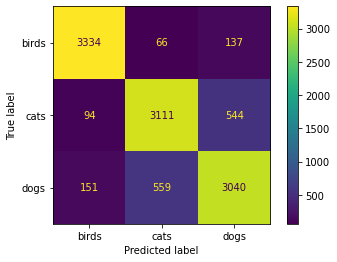

In [38]:
balanced_cm = confusion_matrix(y_true, y_pred_balanced)
ConfusionMatrixDisplay(balanced_cm, display_labels=['birds', 'cats', 'dogs']).plot(values_format="d")

Both accuracy-based metrics are very similar now. The confusion matrix also looks way better than before. This suggests that class imbalance has been successfully mitigated by adding more data to the previously undersampled classes.



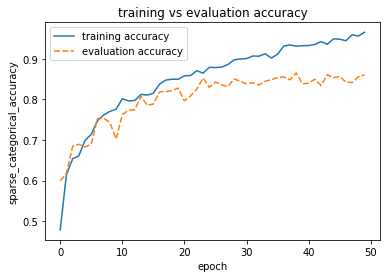

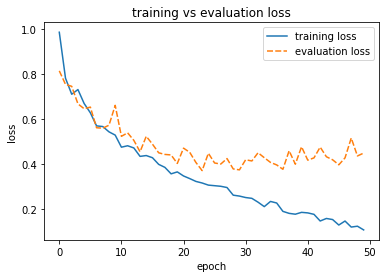

In [39]:
plot_train_eval(balanced_history)

This looks much better than for the imbalanced case! However, overfitting is still present.



# Training with Data Augmentation


In [40]:
# Create a model to use with the balanced and augmented dataset
augmented_model = create_model()

In [41]:
# Now applying image augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Still pointing to directory with full dataset
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'eval',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 25750 images belonging to 3 classes.
Found 11036 images belonging to 3 classes.



Transformation number: 0



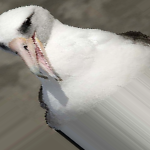


Transformation number: 1



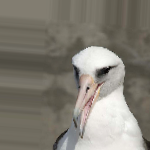


Transformation number: 2



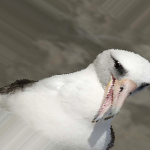


Transformation number: 3



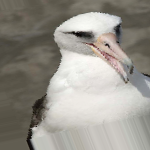

In [43]:
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img


# Displays transformations on random images of birds in the training partition
def display_transformations(gen):
  train_birds_dir = "train/birds"
  random_index = random.randint(0, len(os.listdir(train_birds_dir)))
  sample_image = load_img(f"{os.path.join(train_birds_dir, os.listdir(train_birds_dir)[random_index])}", target_size=(150, 150))
  sample_array = img_to_array(sample_image)
  sample_array = sample_array[None, :]


  for iteration, array in zip(range(4), gen.flow(sample_array, batch_size=1)):
    array = np.squeeze(array)
    img = array_to_img(array)
    print(f"\nTransformation number: {iteration}\n")
    display(img)


# An example of an ImageDataGenerator
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=50,
        width_shift_range=0.25,
        height_shift_range=0.25,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True)

display_transformations(sample_gen)

Let's look at another more extreme example:


Transformation number: 0



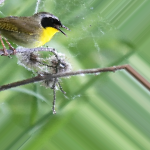


Transformation number: 1



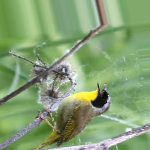


Transformation number: 2



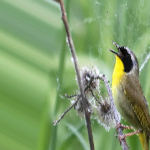


Transformation number: 3



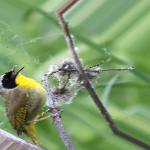

In [44]:
# An ImageDataGenerator with more extreme data augmentation
sample_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=90,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.5,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True)

display_transformations(sample_gen)

In [45]:
#Run only if you want to train the model yourself (this takes around 20 mins with GPU enabled)

augmented_history = augmented_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=80,
    validation_data=validation_generator,
    validation_steps=80)

Epoch 1/80
100/100 [==============================] - 17s 169ms/step - loss: 1.0089 - sparse_categorical_accuracy: 0.4425 - val_loss: 0.8054 - val_sparse_categorical_accuracy: 0.6016
Epoch 2/80
100/100 [==============================] - 16s 164ms/step - loss: 0.8543 - sparse_categorical_accuracy: 0.5938 - val_loss: 0.8499 - val_sparse_categorical_accuracy: 0.5914
Epoch 3/80
100/100 [==============================] - 17s 166ms/step - loss: 0.8392 - sparse_categorical_accuracy: 0.5962 - val_loss: 0.9551 - val_sparse_categorical_accuracy: 0.5727
Epoch 4/80
100/100 [==============================] - 17s 168ms/step - loss: 0.7927 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.7569 - val_sparse_categorical_accuracy: 0.6441
Epoch 5/80
100/100 [==============================] - 17s 167ms/step - loss: 0.7934 - sparse_categorical_accuracy: 0.6131 - val_loss: 0.9910 - val_sparse_categorical_accuracy: 0.5539
Epoch 6/80
100/100 [==============================] - 17s 168ms/step - loss: 0.7782 -

100/100 [==============================] - 17s 169ms/step - loss: 0.4841 - sparse_categorical_accuracy: 0.8009 - val_loss: 0.6207 - val_sparse_categorical_accuracy: 0.7605
Epoch 46/80
100/100 [==============================] - 18s 175ms/step - loss: 0.4954 - sparse_categorical_accuracy: 0.7872 - val_loss: 0.4872 - val_sparse_categorical_accuracy: 0.7977
Epoch 47/80
100/100 [==============================] - 17s 166ms/step - loss: 0.4490 - sparse_categorical_accuracy: 0.8078 - val_loss: 0.6395 - val_sparse_categorical_accuracy: 0.7285
Epoch 48/80
100/100 [==============================] - 17s 168ms/step - loss: 0.4738 - sparse_categorical_accuracy: 0.8031 - val_loss: 0.4432 - val_sparse_categorical_accuracy: 0.8195
Epoch 49/80
100/100 [==============================] - 17s 170ms/step - loss: 0.4470 - sparse_categorical_accuracy: 0.8119 - val_loss: 0.6870 - val_sparse_categorical_accuracy: 0.7281
Epoch 50/80
100/100 [==============================] - 17s 168ms/step - loss: 0.4488 - spars

Since you know that class imbalance is no longer an issue there is no need to check for more in-depth metrics. 

Let's plot the training history right away:

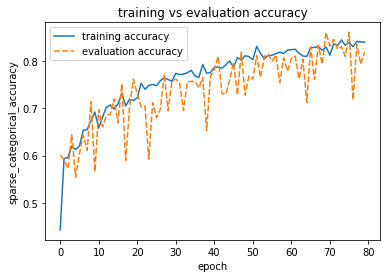

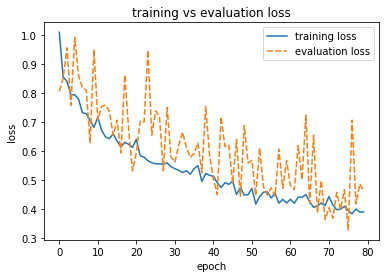

In [46]:
plot_train_eval(augmented_history)

Now, the evaluation accuracy follows more closely the training one. This indicates that **the model is no longer overfitting**. Quite a remarkable finding, achieved by just augmenting the data set.
